**Author**: J W Debelius<br/>
**Date**: 15 September 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

# Number of iterations

The purpose of this notebook is to simulate the number of iterations required to collapase power onto a central limit theorm by varying two parameters, `num_runs` and `num_iter`. The `num_iter` refers to the number of tests performed, and then combined to calculate the power. The `num_runs` determines how many of these emperical power values are averaged for the effect size calculation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skbio
import scipy
import skbio

import absloute_power.utils as ap

from matplotlib import rcParams
from skbio.stats.power import subsample_power
import absloute_power.utils as ap

We'll also set it up so that anything that is plotted here is plotted using Helvetica.

In [2]:
# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True


We'll also set a random seed, so that hte values that come out are consistent.

In [4]:
np.random.seed(25)

We'll start by simulating a pair of distributions which we can test with a two-sample t test.

In [3]:
# Defines the test
def practice_test(sample):
    return scipy.stats.ttest_1samp(sample[0], 0)[1]

# Defines the sample
sample1 = np.random.randn(1000) * 10 + 2.5

# Tests the over all distributions
practice_test([sample1])

5.5004381771596528e-12

Let's vary the number of samples that we iterate over, between 10 and 5000 tests per iteration. We'll do 100 runs, and use that to calculate the power.

In [9]:
num_iter = [10, 50, 100, 500, 1000, 5000]
num_runs = 100
power = []

# for ni in num_iter:
#     power.append(
#         subsample_power(practice_test,
#                         [sample1],
#                         min_counts=10,
#                         max_counts=40,
#                         counts_interval=10,
#                         num_runs=num_runs,
#                         num_iter=ni)
#     )
#     print ni

Now, let's convert the power to effect size, using statsmodels. This is what we typically use when the data is underpowered.

In [7]:
effs = []
for (pwr, cnt) in power:
    eff = []
    for i, r in enumerate(pwr):
        try:
            eff.append(ap.z_effect(counts=cnt, power=r))
        except:
            eff.append(np.array([1, 1, 1])*np.nan)
    effs.append(eff)
    

Finally, we're going to put together a set of plots. We'll define a set of helper functions to let us manipulate the effect size results, and then to plot them.

In [5]:
color1 = np.array([0.45, 0.45, 0.45])
def all_e(eff):
    """Gets all the effect size values"""
    flat = np.hstack(eff)
    return flat[np.isnan(flat) == False]

def calc_e(eff, num_draws=3, runs=25):
    """..."""
    flat = np.array([
        np.nanmean(np.random.choice(np.hstack(eff), num_draws))
        for i in xrange(runs)
        ])
    return flat[np.isnan(flat) == False]

def plot_e(ax, e, counts, pwr_alpha=0.05, color=color1, opac=0.1):
    ax.plot(counts,
            ap.z_power(counts, e, alpha=pwr_alpha), 
            '-',
            color=color,
            alpha=opac,
            linewidth=0.5)

def plot_mean(ax, eff, counts):
    ax.plot(counts, ap.z_power(counts, np.nanmean(eff), 0.05), 'r-', linewidth=0.5)

We'll also define parameters for plotting the data. We'll plot 100 iterations for each set, with values betwen 2 and 100. The critical value is 0.05. We'll combined data for 1, 3, 5, 10, and 25 sets of runs.

In [6]:
counts = np.arange(2.5, 101, 2.5)
runs = 100
alpha = 0.05
fs=10

num_draws = [(1, all_e), 
             (3, lambda x: calc_e(x, 3, runs)),
             (5, lambda x: calc_e(x, 5, runs)),
             (10, lambda x: calc_e(x, 10, runs)),
             (25, lambda x: calc_e(x, 25, runs)),
            ]

In [10]:
len(num_draws)

5

Finally, we'll plot the data.

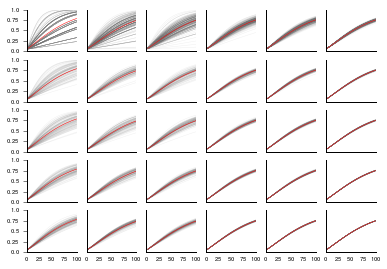

In [13]:
% matplotlib inline
mean_eff = np.zeros((len(num_iter), len(num_draws)))
std_eff = np.zeros((len(num_iter), len(num_draws)))

fig1 = plt.figure()
fig1.set_size_inches((6.25, 5.25))

for idy, eff in enumerate(effs):
    for idx, (num_draw, f_) in enumerate(num_draws):
        eff = np.hstack(eff)
        
#         fn = '/Users/jwdebelius/Desktop/power_figs/iter/images/%i_runs_%i_iter.pdf' % (num_draw, num_iter[idy])
        
        ef2 = f_(eff)
        
        mean_eff[idy, idx] = ef2.mean()
        std_eff[idy, idx] = ef2.std() / np.sqrt(len(ef2))
        # Creates the summary figure for the notebook
        ax1 = fig1.add_subplot(6, 6, idx * 6 + idy + 1)
        for e in ef2:
            plot_e(ax1, e, counts, alpha, opac=0.1)
        plot_mean(ax1, eff, counts)
        ax1.set_xticks(np.arange(0, 101, 25))
        ax1.set_yticks(np.arange(0, 1.1, 0.25))
        # Cleans up the axis
        ap.format_ax(ax1,
                     xlim=[0, 100], 
                     ylim=[0, 1], 
                     show_x=(idx==4),
                     show_y=(idy==0),
                     xticks=np.arange(0, 101, 25),
                     yticks=np.arange(0, 1.1, 0.25),
                     fontsize1=6)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.yaxis.set_ticks_position('left')
        ax1.xaxis.set_ticks_position('bottom')
        if idx == 5:
            ax1.get_xaxis().set_tick_params(direction='out')
        else:
            ax1.get_xaxis().set_tick_params(tick1On=False, tick2On=False)
        if idy == 0:
            ax1.get_yaxis().set_tick_params(direction='out')
        else:
            ax1.get_yaxis().set_tick_params(tick1On=False, tick2On=False)
        
fig1.savefig('/Users/jwdebelius/Desktop/iter.pdf')

We'll also do an effect-size based sweep.

In [7]:
effects = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5])

In [10]:
std = 5
couples = []
for effect in effects:
    # Simulates the new sample
    new_mean = effect * std
    sample1 = np.random.randn(1000) * std + new_mean
    cohen = ap.cohen_d_one_sample(sample1, 0)
    print effect
    
    for ni in num_iter:
        pwr, cnt = subsample_power(practice_test,
                                   [sample1],
                                   min_counts=15,
                                   max_counts=40,
                                   counts_interval=10,
                                   num_runs=num_runs,
                                   num_iter=ni)
        eff = []
        for i, r in enumerate(pwr):
            try:
                eff.append(ap.z_effect(counts=cnt, power=r))
            except:
                pass
        eff = np.hstack(eff)
        for num_draw, f_ in num_draws:
            ef2 = f_(eff)
            power = ap.z_power(25, ef2)
            couples.append((effect, ni, num_draw, cohen, ef2.mean(), ef2.std() / np.sqrt(len(ef2)), ef2.min(), ef2.max(), ef2, power))
        print ni

0.05
10
50
100
500
1000
5000
0.1
10
50
100
500
1000
5000
0.25
10
50
100
500
1000
5000
0.5
10
50
100
500
1000
5000
0.75
10
50
100
500
1000
5000
1.0
10
50
100
500
1000
5000
1.25
10
50
100
500
1000
5000
1.5
10


IndexError: list index out of range

In [11]:
counts

array([   2.5,    5. ,    7.5,   10. ,   12.5,   15. ,   17.5,   20. ,
         22.5,   25. ,   27.5,   30. ,   32.5,   35. ,   37.5,   40. ,
         42.5,   45. ,   47.5,   50. ,   52.5,   55. ,   57.5,   60. ,
         62.5,   65. ,   67.5,   70. ,   72.5,   75. ,   77.5,   80. ,
         82.5,   85. ,   87.5,   90. ,   92.5,   95. ,   97.5,  100. ])

In [12]:
import pandas as pd
couple_frame = pd.DataFrame(data=couples, columns=['original_effect', 'num_iter', 'num_draw',
                                                             'cohen_d', 'mean_effect', 'ci_effect', 'min_eff',
                                                             'max_eff', 'effects', 'power'])

In [13]:
couple_frame['adj_effect'] = couple_frame['mean_effect'] / np.sqrt(2)
couple_frame['adj_std'] = couple_frame['ci_effect'] / np.sqrt(2)
couple_frame['range'] = couple_frame['max_eff'] - couple_frame['min_eff']
couple_frame['adj_eff_ratio'] = couple_frame['adj_effect'] / couple_frame.original_effect
couple_frame['adj_std_ratio'] = couple_frame.adj_std / couple_frame.original_effect
couple_frame['adj_range'] = couple_frame.range / np.sqrt(2) / couple_frame.original_effect
couple_frame['adj_min'] = couple_frame.min_eff / np.sqrt(2)
couple_frame['adj_max'] = couple_frame.max_eff / np.sqrt(2)


couple_frame['power_range'] = couple_frame.power.apply(lambda x: np.nanmax(x)) - couple_frame.power.apply(lambda x: np.nanmin(x))

In [14]:
piv10 = couple_frame[couple_frame.num_iter == 10].pivot('original_effect', 'num_draw', 'adj_range')
# piv50 = couple_frame[couple_frame.num_iter == 50].pivot('original_effect', 'num_draw', 'adj_range')
# piv100 = couple_frame[couple_frame.num_iter == 100].pivot('original_effect', 'num_draw', 'adj_range')
# piv500 = couple_frame[couple_frame.num_iter == 500].pivot('original_effect', 'num_draw', 'adj_range')
# piv1k = couple_frame[couple_frame.num_iter == 1000].pivot('original_effect', 'num_draw', 'adj_range')
# piv5k = couple_frame[couple_frame.num_iter == 5000].pivot('original_effect', 'num_draw', 'adj_range')

In [15]:
piv1

NameError: name 'piv1' is not defined

In [46]:
import pickle
with open('/Users/jwdebelius/Desktop/iterations.p', 'wb') as f_:
    pickle.dump(couple_frame, f_)

In [19]:
%matplotlib inline

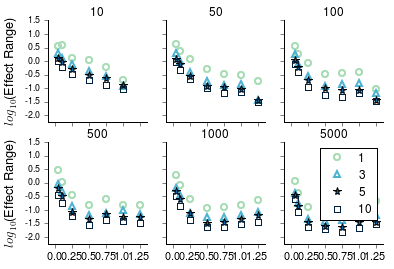

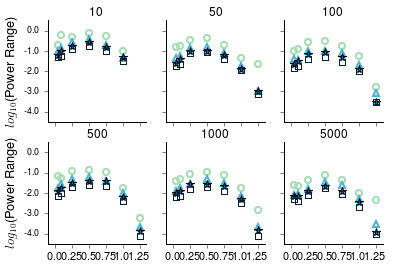

In [45]:
fig1 = plt.figure()
fig2 = plt.figure()
fig1.set_size_inches((6, 4))
fig2.set_size_inches((6, 4))
for idx, iter_ in enumerate(num_iter):
    ax1 = fig1.add_subplot(2, 3, idx + 1)
    ax2 = fig2.add_subplot(2, 3, idx + 1)
    
    piv1 = np.log10(couple_frame[couple_frame.num_iter == iter_].pivot('original_effect', 'num_draw', 'adj_range'))
    piv2 = np.log10(couple_frame[couple_frame.num_iter == iter_].pivot('original_effect', 'num_draw', 'power_range'))
    
    ax1.plot(piv1.index, piv1[ 1], 'o', mfc='none', mec=[168./255, 221./255, 181./255], mew=2, label='1')
    ax1.plot(piv1.index, piv1[ 5], '^', mfc='none', mec=[78./255, 179./255, 211./255], mew=2, label='5')
    ax1.plot(piv1.index, piv1[10], '*', color=[ 8./255, 104./255, 172./255], mew=1, ms=8, label='10')
    ax1.plot(piv1.index, piv1[25], 's', mfc='none', mec=[0, 32./255, 62./255], mew=1, ms=6, label='25')
    
    ax2.plot(piv2.index, piv2[ 1], 'o', mfc='none', mec=[168./255, 221./255, 181./255], mew=2, label='1')
    ax2.plot(piv2.index, piv2[ 5], '^', mfc='none', mec=[78./255, 179./255, 211./255], mew=2, label='5')
    ax2.plot(piv2.index, piv2[10], '*', color=[ 8./255, 104./255, 172./255], mew=1, ms=8, label='10')
    ax2.plot(piv2.index, piv2[25], 's', mfc='none', mec=[0, 32./255, 62./255], mew=1, ms=6, label='25')
        
    ax1.set_ylim([-2.25, 1.25])
    ax2.set_ylim([-4.5, 0.5])
    ax1.set_xlim([0, 1.25])
    ax1.set_yticks(np.arange(-2, 1.6, 0.5))
    ax2.set_yticks(np.arange(-4., 0.1, 1.))
    ax1.set_xticks(np.arange(0, 1.5, 0.5))
    if idx in {0, 3}:
        ax1.set_yticklabels(ax1.get_yticks(), size=9)
        ax1.set_ylabel('${log}_{{10}}$(Effect Range)', size=13)
        ax2.set_yticklabels(ax2.get_yticks(), size=9)
        ax2.set_ylabel('$log_{10}$(Power Range)', size=13)
    else:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
        
    ax1.set_xlim([-0.1, 1.35])
    ax1.set_xticks(np.arange(0, 1.3, 0.25))
    
    ax2.set_xlim([-0.1, 1.35])
    ax2.set_xticks(np.arange(0, 1.3, 0.25))
    
    if idx > 2:
        ax1.set_xticklabels(ax1.get_xticks(), size=11)
        ax2.set_xticklabels(ax2.get_xticks(), size=11)
    else:
        ax1.set_xticklabels('')
        ax2.set_xticklabels('')

    ax1.set_title(iter_)
    ax2.set_title(iter_)
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.get_xaxis().set_tick_params(direction='out')
    ax1.get_yaxis().set_tick_params(direction='out')
    
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.get_yaxis().set_tick_params(direction='out')
    
# from matplotlib.legend_handler import HandlerLine2D
l = ax1.legend(piv1.columns, numpoints=1)


fig1.savefig('/Users/jwdebelius/Desktop/range1.pdf')
fig2.savefig('/Users/jwdebelius/Desktop/range2.pdf')

In [227]:
np.power(2., -4.)

0.0625

In [204]:
piv2

num_draw,1.0,3.0,5.0,10.0,25.0
original_effect,,,,,
0.1,0.097402,0.098590,0.097795,0.098152,0.097582
0.2,0.185351,0.185257,0.185653,0.185231,0.185306
0.3,0.297324,0.296701,0.297433,0.297394,0.297487
0.4,0.404186,0.404808,0.405621,0.404235,0.403416
0.5,0.470060,0.471015,0.470404,0.471135,0.470428
0.6,0.573892,0.572926,0.573348,0.572242,0.574852
0.7,0.591156,0.590918,0.591080,0.590993,0.591669
0.8,0.750113,0.750761,0.749641,0.749867,0.749745
0.9,0.842629,0.836409,0.844734,0.842277,0.842883


In [159]:
couple_frame.loc[(couple_frame.num_iter == 10) & (couple_frame.original_effect.apply(lambda x: x > 1))]

,original_effect,num_iter,num_draw,cohen_d,mean_effect,ci_effect,min_eff,max_eff,adj_effect,adj_std,range,eff_ratio,adj_eff_ratio,adj_std_ratio,adj_range
300,1.1,10,1,1.087313,1.308273,2.052466e-02,0.763222,1.449650,0.925089,1.451312e-02,0.686428,1.203217,0.850803,1.334769e-02,0.446401
301,1.1,10,3,1.087313,1.295729,1.086847e-02,0.992462,1.449650,0.916219,7.685168e-03,0.457188,1.191680,0.842645,7.068036e-03,0.297320
302,1.1,10,5,1.087313,1.302315,8.331448e-03,1.096382,1.449650,0.920876,5.891224e-03,0.353268,1.197737,0.846928,5.418148e-03,0.229739
303,1.1,10,10,1.087313,1.302987,5.502576e-03,1.178986,1.410301,0.921351,3.890909e-03,0.231316,1.198355,0.847365,3.578462e-03,0.150430
304,1.1,10,25,1.087313,1.310593,3.663547e-03,1.197845,1.387603,0.926729,2.590519e-03,0.189758,1.205350,0.852311,2.382496e-03,0.123404
330,1.2,10,1,1.249042,1.384847,1.663666e-02,1.111042,1.449650,0.979235,1.176389e-02,0.338608,1.108728,0.783989,9.418337e-03,0.191693
331,1.2,10,3,1.249042,1.385760,6.462970e-03,1.223911,1.449650,0.979880,4.570010e-03,0.225739,1.109459,0.784506,3.658813e-03,0.127795
332,1.2,10,5,1.249042,1.387495,4.828326e-03,1.274858,1.449650,0.981107,3.414142e-03,0.174792,1.110848,0.785488,2.733409e-03,0.098953
333,1.2,10,10,1.249042,1.382545,3.707792e-03,1.269370,1.449650,0.977607,2.621805e-03,0.180280,1.106884,0.782686,2.099053e-03,0.102060
334,1.2,10,25,1.249042,1.385440,2.000347e-03,1.336905,1.420366,0.979654,1.414459e-03,0.083461,1.109203,0.784325,1.132436e-03,0.047249


In [157]:
couple_frame

,original_effect,num_iter,num_draw,cohen_d,mean_effect,ci_effect,min_eff,max_eff,adj_effect,adj_std,range,eff_ratio,adj_eff_ratio,adj_std_ratio,adj_range
0,0.1,10,1,0.082918,0.274858,8.721574e-03,0.175165,0.763222,0.194354,6.167084e-03,0.588057,3.314826,2.343936,7.437597e-02,5.014841
1,0.1,10,3,0.082918,0.274306,5.649752e-03,0.175165,0.443802,0.193963,3.994978e-03,0.268637,3.308169,2.339229,4.818004e-02,2.290884
2,0.1,10,5,0.082918,0.265533,3.949544e-03,0.190912,0.409063,0.187760,2.792749e-03,0.218151,3.202370,2.264417,3.368098e-02,1.860350
3,0.1,10,10,0.082918,0.268968,3.027785e-03,0.207221,0.392862,0.190189,2.140968e-03,0.185642,3.243796,2.293710,2.582039e-02,1.583117
4,0.1,10,25,0.082918,0.273453,2.303397e-03,0.232376,0.364892,0.193360,1.628748e-03,0.132516,3.297883,2.331956,1.964294e-02,1.130073
5,0.1,50,1,0.082918,0.131035,4.811989e-03,0.024215,0.393389,0.092655,3.402590e-03,0.369174,1.580297,1.117438,4.103575e-02,3.148246
6,0.1,50,3,0.082918,0.139815,4.457597e-03,0.047341,0.274250,0.098864,3.151997e-03,0.226910,1.686193,1.192319,3.801356e-02,1.935043
7,0.1,50,5,0.082918,0.134538,3.929750e-03,0.053574,0.252022,0.095133,2.778753e-03,0.198448,1.622552,1.147317,3.351218e-02,1.692327
8,0.1,50,10,0.082918,0.133777,2.377704e-03,0.073290,0.196257,0.094595,1.681291e-03,0.122967,1.613374,1.140828,2.027662e-02,1.048641
9,0.1,50,25,0.082918,0.129643,1.659459e-03,0.094465,0.164393,0.091671,1.173415e-03,0.069928,1.563512,1.105570,1.415156e-02,0.596331


(1, 3.6)

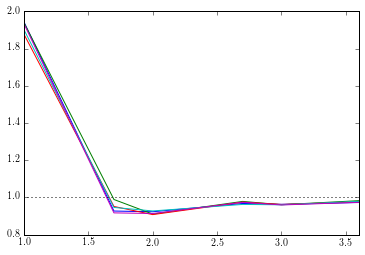

In [132]:
plt.plot(np.log10(couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 1)]['num_iter']),
         couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 1)]['mean_effect'] / np.sqrt(2) /
         0.1)
plt.plot(np.log10(couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 3)]['num_iter']),
         couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 3)]['mean_effect'] / np.sqrt(2) /
         0.1)
plt.plot(np.log10(couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 5)]['num_iter']),
         couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 5)]['mean_effect'] / np.sqrt(2) /
         0.1)
plt.plot(np.log10(couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 10)]['num_iter']),
         couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 10)]['mean_effect'] / np.sqrt(2) /
         0.1)
plt.plot(np.log10(couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 25)]['num_iter']),
         couple_frame[(couple_frame.original_effect == 0.1) & (couple_frame.num_draw == 25)]['mean_effect'] / np.sqrt(2) /
         0.1)

plt.plot([0, 5], [1, 1], 'k:')
ax = plt.gca()
ax.set_xlim([1, 3.6])

In [76]:
plt.plot(couple_frame[couple_frame.original_effect == 0.1, 'cohen_d'].values,
             couple_frame[couple_frame.original_effect == 0.1, 'mean_effect'].values)

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [69]:
couple_frame

,original effect,number iter,num_draw,cohen d,mean effect,ci effect,min eff,max eff,adj effect,adj std
0,0.1,10,1,0.082918,0.274858,8.721574e-03,0.175165,0.763222,0.194354,6.167084e-03
1,0.1,10,3,0.082918,0.274306,5.649752e-03,0.175165,0.443802,0.193963,3.994978e-03
2,0.1,10,5,0.082918,0.265533,3.949544e-03,0.190912,0.409063,0.187760,2.792749e-03
3,0.1,10,10,0.082918,0.268968,3.027785e-03,0.207221,0.392862,0.190189,2.140968e-03
4,0.1,10,25,0.082918,0.273453,2.303397e-03,0.232376,0.364892,0.193360,1.628748e-03
5,0.1,50,1,0.082918,0.131035,4.811989e-03,0.024215,0.393389,0.092655,3.402590e-03
6,0.1,50,3,0.082918,0.139815,4.457597e-03,0.047341,0.274250,0.098864,3.151997e-03
7,0.1,50,5,0.082918,0.134538,3.929750e-03,0.053574,0.252022,0.095133,2.778753e-03
8,0.1,50,10,0.082918,0.133777,2.377704e-03,0.073290,0.196257,0.094595,1.681291e-03
9,0.1,50,25,0.082918,0.129643,1.659459e-03,0.094465,0.164393,0.091671,1.173415e-03
